In [1]:
%matplotlib inline

In [2]:
# !pip install wandb

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import wandb

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
API_KEY = 'e1e534a4439795735bad9f7d91519924c73589c7'
wandb.login(key=API_KEY)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: abhijeet001. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/guest1/.netrc


True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# pip install gdown

In [7]:
# import gdown
# # Google Drive file URL
# # 16yBIEtMjkb-8pmiHOk84YaLXpHrX25cW
# url = 'https://drive.google.com/uc?export=download&id=16yBIEtMjkb-8pmiHOk84YaLXpHrX25cW'
# # Path to save the downloaded file
# output_file = 'my_aksharantar_dataset_sampled.zip'
# # Download the file
# gdown.download(url, output_file, quiet=False)

In [8]:
# !unzip my_aksharantar_dataset_sampled.zip

In [9]:
TRAIN_PATH = 'aksharantar_sampled/hin/hin_train.csv'
VAL_PATH = 'aksharantar_sampled/hin/hin_valid.csv'
TEST_PATH = 'aksharantar_sampled/hin/hin_test.csv'

In [10]:
PAD_token = 0
SOS_token = 1
EOS_token = 2
UNK_token = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3:"UNK"}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in list(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.


In [11]:
# import csv

# with open(TRAIN_PATH, 'r') as csv_file:
#     csv_reader = csv.reader(csv_file)

#     with open('content/eng_hin_train.txt', 'w') as txt_file:
#         for row in csv_reader:
#             txt_file.write(','.join(row) + '\n')

# with open(VAL_PATH, 'r') as csv_file:
#     csv_reader = csv.reader(csv_file)

#     with open('content/eng_hin_val.txt', 'w') as txt_file:
#         for row in csv_reader:
#             txt_file.write(','.join(row) + '\n')

# with open(TEST_PATH, 'r') as csv_file:
#     csv_reader = csv.reader(csv_file)

#     with open('content/eng_hin_test.txt', 'w') as txt_file:
#         for row in csv_reader:
#             txt_file.write(','.join(row) + '\n')

In [12]:
import os
import csv

# Directory path
directory = 'content/'

# Check if the directory exists, if not create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Function to create text files from CSV
def create_text_file(csv_path, txt_path):
    with open(csv_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        with open(txt_path, 'w') as txt_file:
            for row in csv_reader:
                txt_file.write(','.join(row) + '\n')

# Create text files for train, validation, and test datasets
create_text_file(TRAIN_PATH, directory + 'eng_hin_train.txt')
create_text_file(VAL_PATH, directory + 'eng_hin_val.txt')
create_text_file(TEST_PATH, directory + 'eng_hin_test.txt')


In [13]:
# # SAMPLE_SIZE = 10000
# # add path
# def readLangs(lang1, lang2, file_type = 'train', reverse=False):
# # def readLangs(lang1, lang2, file_type = 'train', reverse=False):
#     print("Reading lines...")

#     # Read the file and split into lines
#     # lines = open(path, encoding='utf-8').\
#     lines = open('content/%s_%s_%s.txt' % (lang1, lang2, file_type), encoding='utf-8').\
#         read().strip().split('\n')

#     # Split every line into pairs and normalize
#     pairs = [[s for s in l.split(',')] for l in lines]

#     # # Reverse pairs, make Lang instances
#     # if reverse:
#     #     pairs = [list(reversed(p)) for p in pairs]
#     #     input_lang = Lang(lang2)
#     #     output_lang = Lang(lang1)
#     # else:
#     input_lang = Lang(lang1)
#     output_lang = Lang(lang2)

#     # return input_lang, output_lang, pairs[:SAMPLE_SIZE]
#     return input_lang, output_lang, pairs

In [14]:
# Read language pairs from file
def readLangs(lang1, lang2, file_type='train', reverse=False):
    print("Reading lines...")
    lines = open(f'content/{lang1}_{lang2}_{file_type}.txt', encoding='utf-8').read().strip().split('\n')
    pairs = [l.split(',') for l in lines]

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

MAX_LENGTH = 30

# Filter out pairs longer than MAX_LENGTH
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Prepare data and create language instances
def prepareData(lang1, lang2, file_type='train', reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, file_type, reverse)
    print(f"Read {len(pairs)} word pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} word pairs")
    print("Counting chars...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'hin', file_type='train', reverse=False)
print(random.choice(pairs))

Reading lines...
Read 51200 word pairs
Trimmed to 51200 word pairs
Counting chars...
Counted chars:
eng 30
hin 68
['manufacturers', 'मैन्यूफैक्चर्रस']


Since there are a *lot* of example sentences and we want to train
something quickly, we\'ll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we\'re filtering to sentences that translate to
the form \"I am\" or \"He is\" etc. (accounting for apostrophes replaced
earlier).


In [15]:
MAX_LENGTH = 50

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-   Read text file and split into lines, split lines into pairs
-   Normalize text, filter by length and content
-   Make word lists from sentences in pairs


In [16]:
def prepareData(lang1, lang2, file_type = 'train', reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, file_type)
    print("Read %s word pairs" % len(pairs))
    print(pairs)
    pairs = filterPairs(pairs)
    print("Trimmed to %s word pairs" % len(pairs))
    print("Counting chars...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'hin', file_type = 'train', reverse = False)
print(random.choice(pairs))

Reading lines...
Read 51200 word pairs
[['shastragaar', 'शस्त्रागार'], ['bindhya', 'बिन्द्या'], ['kirankant', 'किरणकांत'], ['yagyopaveet', 'यज्ञोपवीत'], ['ratania', 'रटानिया'], ['vaganyache', 'वागण्याचे'], ['deshbharamadhye', 'देशभरामध्ये'], ['sughadpan', 'सुघड़पन'], ['mohiwal', 'मोहीवाल'], ['sarvasangrah', 'सर्वसंग्रह'], ['baseko', 'बसेको'], ['tumchyapaiki', 'तुमच्यापैकी'], ['kanyakubja', 'कान्यकुब्ज'], ['intoxination', 'इनटॉक्सिनेशन'], ['maturity', 'मेच्यूरिटी'], ['agri', 'अगरी'], ['anukramanupat', 'अनुक्रमानुपात'], ['dhulchand', 'धूलचन्द'], ['avleha', 'अवलेह'], ['abroard', 'एबरोर्ड'], ['ballers', 'बैलर्स'], ['bavli', 'बार्गली'], ['punctured', 'पंक्चर्ड'], ['hankers', 'हैंकर्स'], ['jawanonke', 'जवानोंके'], ['painki', 'पौंकी'], ['jagandham', 'जगनधाम'], ['ponnium', 'पोन्नियम'], ['inba', 'आईएनबीए'], ['vedalam', 'वेदलम'], ['chinwas', 'चिनवास'], ['maarvaadaa', 'मारवाड़ा'], ['ansamajha', 'अनसमझा'], ['istudent', 'इस्टूडेंट'], ['duhkheet', 'दुःखीत'], ['sighanchi', 'सिघांची'], ['shiksheche', 

In [17]:
#WORKING OK
# ENCODER RNN
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,  rnn_type='gru', num_layers=1, dropout_p=0.1, bidirectional=False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(input_size, hidden_size)

        if rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError("rnn_type not compatible")

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded)
        return output, hidden

In [18]:
# DECODER
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type='gru', num_layers = 1, dropout_p=0.1, bidirectional=False):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)

        if rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

        D = 2 if bidirectional else 1
        self.out = nn.Linear(D * hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = self.out(output)
        return output, hidden #ADD DROUPOUT

In [19]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size) # B, d -> B, d
        self.Ua = nn.Linear(hidden_size, hidden_size) # B, d -> B, d
        self.Va = nn.Linear(hidden_size, 1)# B, d -> B, 1

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys))) # 32, 1
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type = 'gru',  num_layers=1, dropout_p=0.1, bidirectional=False):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)

        if rnn_type == 'gru':
            self.rnn = nn.GRU(2*hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(2*hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            self.rnn = nn.RNN(2*hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)




        # D = 2 if bidirectional else 1
        D = 1
        self.out = nn.Linear(D * hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        # print(encoder_hidden.shape)
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))
        # print(hidden.shape)
        query = hidden.permute(1, 0, 2) # a, b, c -> b, a, c
        # print(query.shape)
        # print(query.shape, encoder_outputs.shape)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [20]:
# class Seq2Seq(nn.Module):
#     def __init__(self, input_size, hidden_size,  rnn_type='gru', num_layers=1, dropout_p=0.1, bidirectional=False):
#         super(Seq2Seq, self).__init__()
#         self.encoer_gru = gru()
#         # self.encoder = EncoderRNN(input_size, hidden_size,  rnn_type='gru', num_layers=1, dropout_p=0.1, bidirectional=False)
#         # self.decoder = DecoderRNN(input_size, hidden_size,  rnn_type='gru', num_layers=1, dropout_p=0.1, bidirectional=False)

#     def encoder():
#         # Encoder forward
#         pass

#     def decoer():
#         # decoder forward
#         pass

#     def forward(self, input):
#         encoder_outputs, encoder_hidden = self.encoder(input)
#         return self.decoder(encoder_outputs, encoder_hidden, target_tensor)

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>There are other forms of attention that work around the lengthlimitation by using a relative position approach. Read about "localattention" in <a href="https://arxiv.org/abs/1508.04025">Effective Approaches to Attention-based Neural MachineTranslation</a>.</p>
</div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.


In [21]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word,2)  for word in list(sentence)]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [22]:
def get_dataloader(batch_size=32):
    input_lang, output_lang, pairs = prepareData('eng', 'hin', file_type = 'train', reverse = False)

    n = len(pairs)
    # print(n)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)

        # Append EOS token
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)

        # Truncate if longer than MAX_LENGTH
        if len(inp_ids) > MAX_LENGTH:
            inp_ids = inp_ids[:MAX_LENGTH]
        if len(tgt_ids) > MAX_LENGTH:
            tgt_ids = tgt_ids[:MAX_LENGTH]

        # Print lengths for debugging
        # print(len(inp_ids))
        # print(len(tgt_ids))

        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader


In [23]:
def get_valdataloader(input_lang, output_lang, data_path, batch_size = 32):
    _, _, pairs = prepareData('eng', 'hin', file_type = 'val', reverse=False)

    n = len(pairs)
    # print(n)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)

        # Append EOS token
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)

        # Truncate if longer than MAX_LENGTH
        if len(inp_ids) > MAX_LENGTH:
            inp_ids = inp_ids[:MAX_LENGTH]
        if len(tgt_ids) > MAX_LENGTH:
            tgt_ids = tgt_ids[:MAX_LENGTH]

        # Print lengths for debugging
        # print(len(inp_ids))
        # print(len(tgt_ids))

        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    val_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    # train_sampler = RandomSampler(train_data)
    val_dataloader = DataLoader(val_data, batch_size=batch_size)
    return input_lang, output_lang, val_dataloader


In [24]:
def get_testdataloader(input_lang, output_lang, data_path, batch_size = 32):
    _, _, pairs = prepareData('eng', 'hin', file_type = 'test', reverse=False)

    n = len(pairs)
    # print(n)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)

        # Append EOS token
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)

        # Truncate if longer than MAX_LENGTH
        if len(inp_ids) > MAX_LENGTH:
            inp_ids = inp_ids[:MAX_LENGTH]
        if len(tgt_ids) > MAX_LENGTH:
            tgt_ids = tgt_ids[:MAX_LENGTH]

        # Print lengths for debugging
        # print(len(inp_ids))
        # print(len(tgt_ids))

        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    test_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    # train_sampler = RandomSampler(train_data)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)
    return input_lang, output_lang, test_dataloader


In [25]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    encoder.train()
    decoder.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    total_tokens = 0
    total_correct_words = 0
    total_words = 0

    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

        if wandb.run:
            wandb.log({"train_batch_loss": loss.item()})

    #     # Calculate accuracy
    #     _, predicted = decoder_outputs.max(2)
    #     correct = predicted.eq(target_tensor)
    #     total_correct += correct.sum().item()
    #     total_samples += correct.numel()

    # accuracy = total_correct / total_samples
    # return total_loss / len(dataloader), accuracy

        # Calculate accuracy
        _, predicted = decoder_outputs.max(2)
        mask = target_tensor != PAD_token
        total_correct += (target_tensor == predicted)[mask].sum().item()
        total_tokens += mask.sum().item()
        total_correct_words += ((predicted != target_tensor).sum(1) == 0).sum().item()
        total_words += len(predicted)
        # _, predicted = decoder_outputs.max(2)
        # non_pad_mask_pred = predicted.ne(PAD_token)  # Mask for non-padded tokens in predicted sequences
        # non_pad_mask_tgt = target_tensor.ne(PAD_token)  # Mask for non-padded tokens in target sequences
        # correct_mask = predicted.eq(target_tensor) & non_pad_mask_pred & non_pad_mask_tgt
        # total_correct += correct_mask.sum().item()
        # total_tokens += non_pad_mask_tgt.sum().item()

    accuracy = total_correct / total_tokens
    total_loss = total_loss / len(dataloader)
    word_accuracy = total_correct_words / total_words
    if wandb.run:
        wandb.log({"train_token_accuracy": accuracy})
        wandb.log({"train_word_accuracy": word_accuracy})
        wandb.log({"train_loss": total_loss})
    return total_loss, word_accuracy


In [26]:
def val_epoch(dataloader, encoder, decoder, criterion, mode="val"):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    total_tokens = 0
    total_correct_words = 0
    total_words = 0

    for data in dataloader:
        input_tensor, target_tensor = data
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )


        total_loss += loss.item()



    #     # Calculate accuracy
    #     _, predicted = decoder_outputs.max(2)
    #     correct = predicted.eq(target_tensor)
    #     total_correct += correct.sum().item()
    #     total_samples += correct.numel()

    # accuracy = total_correct / total_samples
    # return total_loss / len(dataloader), accuracy
        # Calculate accuracy
        # Calculate accuracy
        _, predicted = decoder_outputs.max(2)
        mask = target_tensor != PAD_token
        total_correct += (target_tensor == predicted)[mask].sum().item()
        total_tokens += mask.sum().item()
        total_correct_words += ((predicted != target_tensor).sum(1) == 0).sum().item()
        total_words += len(predicted)

        # non_pad_mask_pred = predicted.ne(PAD_token)  # Mask for non-padded tokens in predicted sequences
        # non_pad_mask_tgt = target_tensor.ne(PAD_token)  # Mask for non-padded tokens in target sequences
        # correct_mask = predicted.eq(target_tensor) & non_pad_mask_pred & non_pad_mask_tgt
        # total_correct += correct_mask.sum().item()
        # total_tokens += non_pad_mask_tgt.sum().item()

    accuracy = total_correct / total_tokens
    total_loss = total_loss / len(dataloader)
    word_accuracy = total_correct_words / total_words
    if wandb.run:
        wandb.log({f"{mode}_token_accuracy": accuracy})
        wandb.log({f"{mode}_word_accuracy": word_accuracy})
        wandb.log({f"{mode}_loss": total_loss})
    return total_loss, word_accuracy

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.


In [27]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-   Start a timer
-   Initialize optimizers and criterion
-   Create set of training pairs
-   Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.


In [28]:
def train(train_dataloader, val_dataloader, test_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
# def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
#                print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss, accuracy = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        val_loss, val_accuracy = val_epoch(val_dataloader, encoder, decoder, criterion, mode='val')

        print(f'Epoch: {epoch}; train_loss: {loss}; train_accuracy: {accuracy}; val_loss: {val_loss}; val_accuracy: {val_accuracy}')

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    test_loss, test_accuracy = val_epoch(test_dataloader, encoder, decoder, criterion, mode='test')
    print(f'test_loss: {test_loss}; test_accuracy: {test_accuracy}')
    showPlot(plot_losses)

Plotting results
================

Plotting is done with matplotlib, using the array of loss values
`plot_losses` saved while training.


In [29]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder\'s predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder\'s
attention outputs for display later.


In [30]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:


In [31]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(pair)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we\'ll get
some reasonable results.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>If you run this notebook you can train, interrupt the kernel,evaluate, and continue training later. Comment out the lines where theencoder and decoder are initialized and run <code>trainIters</code> again.</p>
</div>


In [32]:
wandb.login()

True

In [33]:
########## HYPERPARAMETER TUNING USING WANDB ##########

# Define a training function that takes hyperparameters as arguments
def train_with_wandb():
    # Initialize WandB inside the function
    wandb.init()

    # Fetch hyperparameters from wandb.config
    HIDDEN_SIZE = wandb.config.HIDDEN_SIZE
    BATCH_SIZE = wandb.config.BATCH_SIZE
    NUM_LAYERS_ENCODER = wandb.config.NUM_LAYERS_ENCODER
    NUM_LAYERS_DECODER = wandb.config.NUM_LAYERS_DECODER
    N_EPOCHS = wandb.config.N_EPOCHS
    RNN_TYPE_ENCODER = wandb.config.RNN_TYPE_ENCODER
    RNN_TYPE_DECODER = wandb.config.RNN_TYPE_DECODER
    DROUPOUT = wandb.config.DROUPOUT
    BIDIRECTIONAL = wandb.config.BIDIRECTIONAL
    LEARNING_RATE = wandb.config.LEARNING_RATE
    BEAM_SEARCH_SIZE = wandb.config.BEAM_SEARCH_SIZE

    # Construct run name using config parameters
    run_name = f"batch_size={BATCH_SIZE}_hidden_size={HIDDEN_SIZE}_num_layers_encoder={NUM_LAYERS_ENCODER}_num_layers_decoder={NUM_LAYERS_DECODER}_n_epochs={N_EPOCHS}_rnn_type_encoder={RNN_TYPE_ENCODER}_dropout={DROUPOUT}_bidirectional={BIDIRECTIONAL}_learning_rate={LEARNING_RATE}"
    wandb.run.name = run_name

    input_lang, output_lang, train_dataloader = get_dataloader(batch_size=BATCH_SIZE)
    _, _, val_dataloader = get_valdataloader(
        batch_size=BATCH_SIZE,
        input_lang=input_lang,
        output_lang=output_lang,
        data_path='/content/eng_hin_val.txt'
    )
    _, _, test_dataloader = get_testdataloader(
        batch_size=BATCH_SIZE,
        input_lang=input_lang,
        output_lang=output_lang,
        data_path='/content/eng_hin_test.txt'
    )
    encoder = EncoderRNN(input_lang.n_words, rnn_type=RNN_TYPE_ENCODER, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS_ENCODER, dropout_p=DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)
    decoder = AttnDecoderRNN(hidden_size=HIDDEN_SIZE, output_size=output_lang.n_words, rnn_type=RNN_TYPE_ENCODER, num_layers=NUM_LAYERS_ENCODER, dropout_p=DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)
    train(
        train_dataloader,
        val_dataloader,
        test_dataloader,
        encoder,
        decoder,
        n_epochs=N_EPOCHS,
        learning_rate=LEARNING_RATE,
        print_every=5,
        plot_every=5
    )

# # Define your configuration space for hyperparameters
# sweep_config = {
#     'method': 'bayes',
#     'metric': {'name': 'val_word_accuracy', 'goal': 'maximize'},
#     'parameters': {
#         'HIDDEN_SIZE': {'values': [64, 128, 256]},
#         'BATCH_SIZE': {'values': [128, 256, 512, 1024]},
#         'NUM_LAYERS_ENCODER': {'values': [1]},
#         'NUM_LAYERS_DECODER': {'values': [1]},
#         'N_EPOCHS': {'values': [15, 20, 25, 30, 35, 40, 45, 50]},
#         'RNN_TYPE_ENCODER': {'values': ['gru', 'rnn', 'lstm']},
#         'RNN_TYPE_DECODER': {'values': ['gru', 'rnn', 'lstm']},
#         'DROUPOUT': {'values': [0, 0.1, 0.2]},
#         'BIDIRECTIONAL': {'values': [False]},
#         'LEARNING_RATE': {'values': [0.01, 0.005, 0.002]},
#         'BEAM_SEARCH_SIZE':{'values': [1]}
#     }
# }

############################### best hyp
# Define your configuration space for hyperparameters
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_word_accuracy', 'goal': 'maximize'},
    'parameters': {
        'HIDDEN_SIZE': {'values': [128]},
        'BATCH_SIZE': {'values': [1024]},
        'NUM_LAYERS_ENCODER': {'values': [1]},
        'NUM_LAYERS_DECODER': {'values': [1]},
        'N_EPOCHS': {'values': [35]},
        'RNN_TYPE_ENCODER': {'values': ['gru', 'rnn', 'lstm']},
        'RNN_TYPE_DECODER': {'values': ['gru', 'rnn', 'lstm']},
        'DROUPOUT': {'values': [0.1]},
        'BIDIRECTIONAL': {'values': [False]},
        'LEARNING_RATE': {'values': [0.002]},
        'BEAM_SEARCH_SIZE':{'values': [1]}
    }
}
############################################

# Start a sweep with the defined configuration

# sweep_id = wandb.sweep(sweep_config, project="CS6910_FODL_ASSIGNMENT_03_ATTN", entity="abhijeet001")
# sweep_id = wandb.sweep(sweep_config)
# sweep_id = 'p3eoinfk'
sweep_id = 'c9el6542'

# Run the sweep agent to execute the hyperparameter search
wandb.agent(sweep_id, function=train_with_wandb, count = 100, project="CS6910_FODL_ASSIGNMENT_03_ATTN", entity="abhijeet001")



In [34]:
# Training with best hyperparameter config:
HIDDEN_SIZE = 128
BATCH_SIZE = 1024
MAX_LENGTH = 50
NUM_LAYERS_ENCODER = 1
NUM_LAYERS_DECODER = 1
N_EPOCHS = 35
RNN_TYPE_ENCODER = 'gru'
RNN_TYPE_DECODER = 'gru'
DROUPOUT = 0.1
BIDIRECTIONAL = False
BEAM_SEARCH_SIZE = 1
LEARNING_RATE = 0.005

input_lang, output_lang, train_dataloader = get_dataloader(batch_size = BATCH_SIZE)

_,_,val_dataloader = get_valdataloader(
    batch_size = BATCH_SIZE,
    input_lang=input_lang,
    output_lang=output_lang,
    data_path='/content/eng_hin_val.txt'
)
_,_,test_dataloader = get_testdataloader(
    batch_size = BATCH_SIZE,
    input_lang=input_lang,
    output_lang=output_lang,
    data_path='/content/eng_hin_test.txt'
)

encoder = EncoderRNN(input_lang.n_words, rnn_type=RNN_TYPE_ENCODER, hidden_size = HIDDEN_SIZE, num_layers = NUM_LAYERS_ENCODER, dropout_p=DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)

# decoder = DecoderRNN(hidden_size = HIDDEN_SIZE, output_size = output_lang.n_words, rnn_type=RNN_TYPE_ENCODER, num_layers = NUM_LAYERS_ENCODER, dropout_p = DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)

decoder = AttnDecoderRNN(hidden_size = HIDDEN_SIZE, output_size = output_lang.n_words, rnn_type=RNN_TYPE_ENCODER, num_layers = NUM_LAYERS_ENCODER, dropout_p=0.1, bidirectional=BIDIRECTIONAL).to(device)



Reading lines...
Read 51200 word pairs
[['shastragaar', 'शस्त्रागार'], ['bindhya', 'बिन्द्या'], ['kirankant', 'किरणकांत'], ['yagyopaveet', 'यज्ञोपवीत'], ['ratania', 'रटानिया'], ['vaganyache', 'वागण्याचे'], ['deshbharamadhye', 'देशभरामध्ये'], ['sughadpan', 'सुघड़पन'], ['mohiwal', 'मोहीवाल'], ['sarvasangrah', 'सर्वसंग्रह'], ['baseko', 'बसेको'], ['tumchyapaiki', 'तुमच्यापैकी'], ['kanyakubja', 'कान्यकुब्ज'], ['intoxination', 'इनटॉक्सिनेशन'], ['maturity', 'मेच्यूरिटी'], ['agri', 'अगरी'], ['anukramanupat', 'अनुक्रमानुपात'], ['dhulchand', 'धूलचन्द'], ['avleha', 'अवलेह'], ['abroard', 'एबरोर्ड'], ['ballers', 'बैलर्स'], ['bavli', 'बार्गली'], ['punctured', 'पंक्चर्ड'], ['hankers', 'हैंकर्स'], ['jawanonke', 'जवानोंके'], ['painki', 'पौंकी'], ['jagandham', 'जगनधाम'], ['ponnium', 'पोन्नियम'], ['inba', 'आईएनबीए'], ['vedalam', 'वेदलम'], ['chinwas', 'चिनवास'], ['maarvaadaa', 'मारवाड़ा'], ['ansamajha', 'अनसमझा'], ['istudent', 'इस्टूडेंट'], ['duhkheet', 'दुःखीत'], ['sighanchi', 'सिघांची'], ['shiksheche', 

In [35]:
with wandb.init(project="FODL_Assignment3", entity="abhijeet001"):
    train(
        train_dataloader,
        val_dataloader,
        test_dataloader,
        encoder,
        decoder,
        n_epochs=N_EPOCHS,
        learning_rate=LEARNING_RATE,
        print_every=5, plot_every=5
    )

/home/guest1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 1; train_loss: 0.6835873293876648; train_accuracy: 0.0; val_loss: 0.4352438822388649; val_accuracy: 0.0
Epoch: 2; train_loss: 0.4698013573884964; train_accuracy: 0.0; val_loss: 0.35433802753686905; val_accuracy: 0.000244140625
Epoch: 3; train_loss: 0.36567366123199463; train_accuracy: 0.002734375; val_loss: 0.22701340541243553; val_accuracy: 0.040283203125
Epoch: 4; train_loss: 0.22092040866613388; train_accuracy: 0.0507421875; val_loss: 0.13218771666288376; val_accuracy: 0.14990234375
Epoch: 5; train_loss: 0.1473849245905876; train_accuracy: 0.124765625; val_loss: 0.10997176170349121; val_accuracy: 0.19384765625
0m 33s (- 3m 54s) (5 12%) 0.3775
Epoch: 6; train_loss: 0.11627921283245087; train_accuracy: 0.17791015625; val_loss: 0.08814103342592716; val_accuracy: 0.25341796875
Epoch: 7; train_loss: 0.09991463333368301; train_accuracy: 0.21689453125; val_loss: 0.08388674817979336; val_accuracy: 0.274169921875
Epoch: 8; train_loss: 0.09080382660031319; train_accuracy: 0.2442578125;

In [37]:
import csv

def predict_and_save(input_lang, output_lang, test_dataloader, encoder, decoder, output_file):
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['English Word', 'Hindi Word', 'Predicted Word'])

        for data in test_dataloader:
            input_tensor, target_tensor = data
            for i in range(len(input_tensor)):
                # Convert input_tensor to input_sentence without EOS
                input_sentence = ''.join([input_lang.index2word[idx.item()] for idx in input_tensor[i] if idx.item() != 0 and input_lang.index2word[idx.item()] != 'EOS'])
                # Convert target_tensor to target_sentence without EOS
                target_sentence = ''.join([output_lang.index2word[idx.item()] for idx in target_tensor[i] if idx.item() != 0 and output_lang.index2word[idx.item()] != 'EOS'])
                # Get the predicted words
                output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
                # Exclude <EOS> and <PAD> tokens from predicted words
                predicted_word = ''.join([word for word in output_words if word not in ('EOS', 'PAD', '<EOS>')])
                # Write the results to CSV file
                writer.writerow([input_sentence, target_sentence, predicted_word])
    
    print(f"Predictions saved to {output_file}")

# Replace 'output_file_path.csv' with the path where you want to save the predictions
output_file_path = 'attention_s2s_predictions_3.csv'
predict_and_save(input_lang, output_lang, test_dataloader, encoder, decoder, output_file_path)


Predictions saved to attention_s2s_predictions_3.csv


In [38]:
# encoder.eval()
# decoder.eval()
# evaluateRandomly(encoder, decoder)

In [39]:
# output_words, _ = evaluate(encoder, decoder, "lagsama", input_lang, output_lang)
# ''.join(output_words)

In [40]:
# list("लगसमा")

input = lagsama
output = लगसामा<EOS>


/tmp/ipykernel_75012/1774487158.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(input_sentence) + ['<EOS>'], rotation=90)
/tmp/ipykernel_75012/1774487158.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words,fontproperties=font_prop)


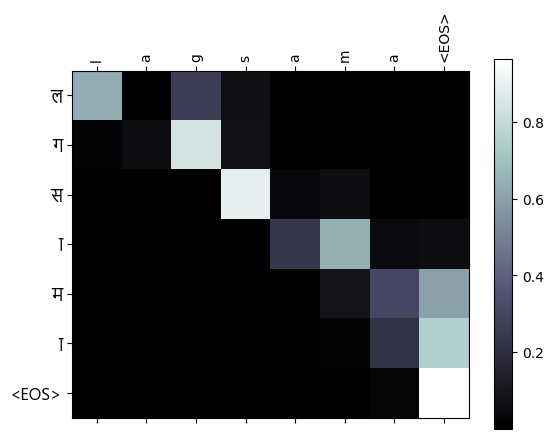

input = hurdy
output = रूरी<EOS>


/tmp/ipykernel_75012/1774487158.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(input_sentence) + ['<EOS>'], rotation=90)
/tmp/ipykernel_75012/1774487158.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words,fontproperties=font_prop)


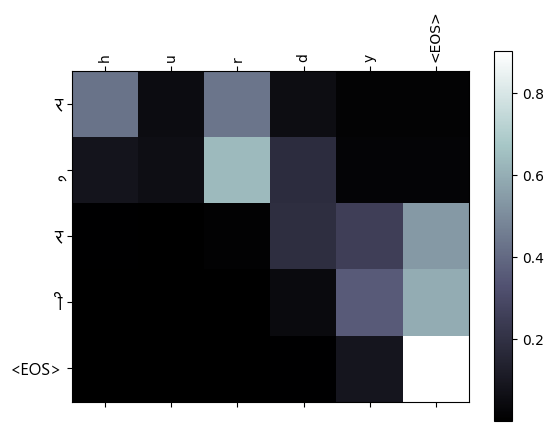

input = lipo
output = पिपो<EOS>


/tmp/ipykernel_75012/1774487158.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(input_sentence) + ['<EOS>'], rotation=90)
/tmp/ipykernel_75012/1774487158.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words,fontproperties=font_prop)


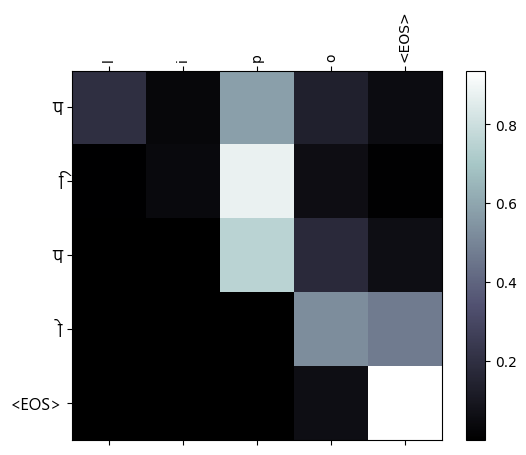

input = vairus
output = रेयस<EOS>


/tmp/ipykernel_75012/1774487158.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(input_sentence) + ['<EOS>'], rotation=90)
/tmp/ipykernel_75012/1774487158.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words,fontproperties=font_prop)


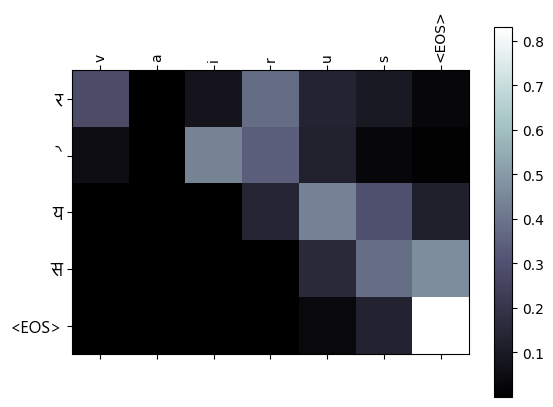

In [43]:
# Visualizing Attention

%matplotlib inline
from matplotlib.font_manager import FontProperties
TTF_PATH = '/mnt/media/guest1/abhijeet/assignments/deep_learning/assignment_03/attention_seq_to_seq/aksharantar_sampled/hin/Nirmala.ttf'
font_prop = FontProperties(fname=TTF_PATH, size=12)
def showAttention(input_sentence, output_words, attentions):


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(input_sentence) + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words,fontproperties=font_prop)


    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ''.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('lagsama')

evaluateAndShowAttention('hurdy')

evaluateAndShowAttention('lipo')

evaluateAndShowAttention('vairus')

Processing example 1
Input: thermax
Target: थरमैक्स
Predicted Output: र्रमैक्स<EOS>


/tmp/ipykernel_75012/1522105019.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/1522105019.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


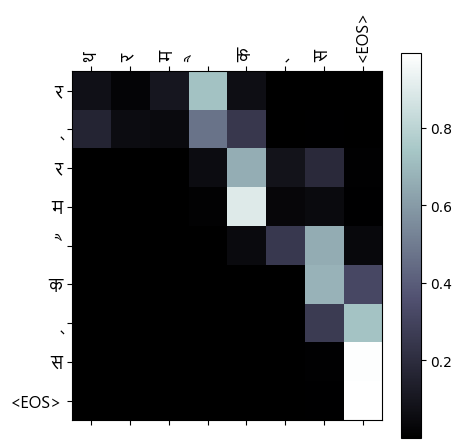

Processing example 2
Input: ummeede
Target: उम्मीदे
Predicted Output: म्मीदे<EOS>


/tmp/ipykernel_75012/1522105019.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/1522105019.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


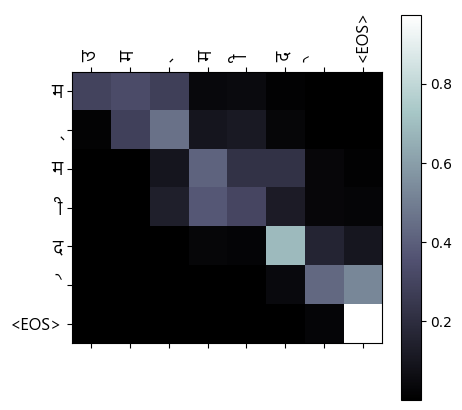

Processing example 3
Input: baabaao
Target: बाबाओ
Predicted Output: आबाओ<EOS>


/tmp/ipykernel_75012/1522105019.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/1522105019.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


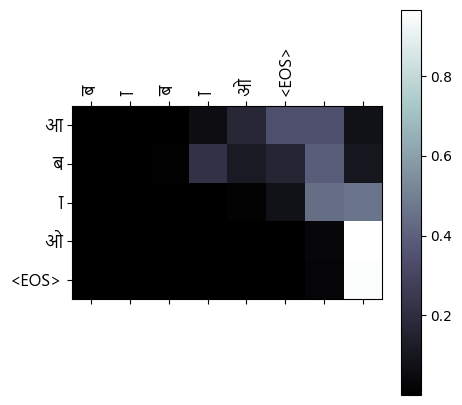

Processing example 4
Input: ralhan
Target: रल्हन
Predicted Output: रहान<EOS>


/tmp/ipykernel_75012/1522105019.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/1522105019.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


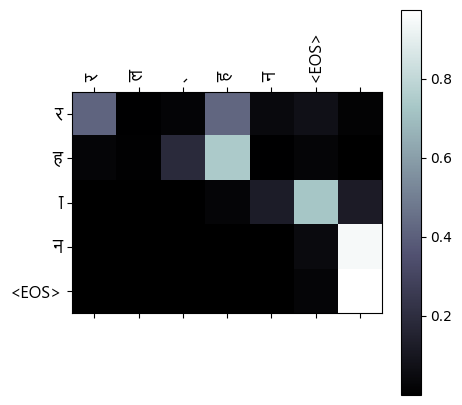

In [74]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import time

TTF_PATH = '/mnt/media/guest1/abhijeet/assignments/deep_learning/assignment_03/attention_seq_to_seq/aksharantar_sampled/hin/Nirmala.ttf'
font_prop = FontProperties(fname=TTF_PATH, size=12)

def showAttention(input_sentence, target_sentence, output_words, attentions):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
    ax.set_yticklabels([''] + output_words, fontproperties=font_prop)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('Input:', input_sentence)
    print('Target:', target_sentence)
    print('Predicted Output:', ''.join(output_words))
    showAttention(input_sentence, target_sentence, output_words, attentions[0, :len(output_words), :])

# Get 10 samples from the test set and visualize attention for each
for i, (input_tensor, target_tensor) in enumerate(test_dataloader):
    print(f"Processing example {i+1}")
    if i == 10:
        break
    input_sentence = ''.join([input_lang.index2word[idx.item()] for idx in input_tensor[0] if idx.item() != 0 and input_lang.index2word[idx.item()] != 'EOS'])
    target_sentence = ''.join([output_lang.index2word[idx.item()] for idx in target_tensor[0] if idx.item() != 0 and output_lang.index2word[idx.item()] != 'EOS'])
    evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang)
    time.sleep(3)

In [70]:
import csv

def get_example_from_csv(csv_file, index):
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        examples = list(reader)
    
    if index < len(examples):
        input_sentence, target_sentence = examples[index]
        return input_sentence, target_sentence
    else:
        print("Index out of range.")
        return None, None


Processing example 1
Input: shastragaar
Target: शस्त्रागार
Predicted Output: स्तारागर<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


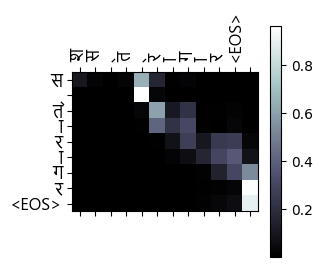

Processing example 2
Input: bindhya
Target: बिन्द्या
Predicted Output: धंध्य<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


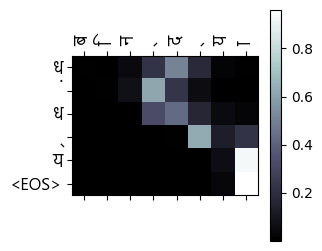

Processing example 3
Input: kirankant
Target: किरणकांत
Predicted Output: किरांकांत<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


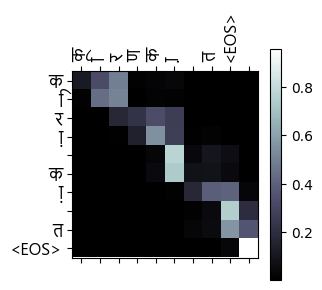

Processing example 4
Input: yagyopaveet
Target: यज्ञोपवीत
Predicted Output: ज्ञोपवीत<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


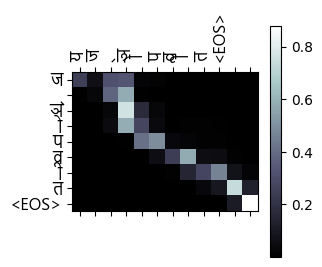

Processing example 5
Input: ratania
Target: रटानिया
Predicted Output: नाताया<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


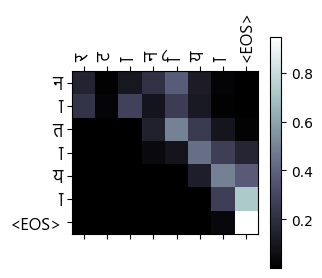

Processing example 6
Input: vaganyache
Target: वागण्याचे
Predicted Output: वांयाचे<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


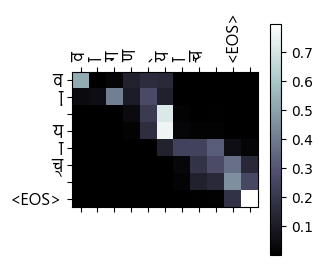

Processing example 7
Input: deshbharamadhye
Target: देशभरामध्ये
Predicted Output: शेझभरमध्ये<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


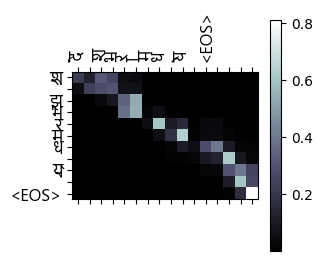

Processing example 8
Input: sughadpan
Target: सुघड़पन
Predicted Output: गढ़ादान<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


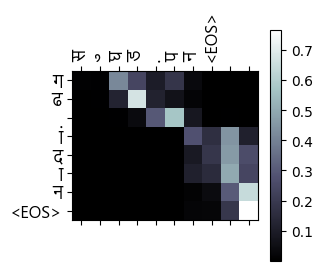

Processing example 9
Input: mohiwal
Target: मोहीवाल
Predicted Output: मोहीवाल<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


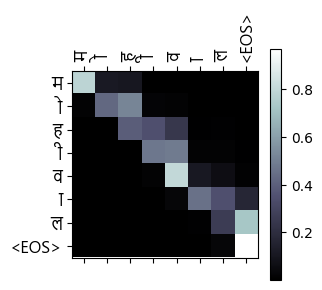

Processing example 10
Input: sarvasangrah
Target: सर्वसंग्रह
Predicted Output: रवसंग्रह<EOS>


/tmp/ipykernel_75012/2909464644.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2909464644.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


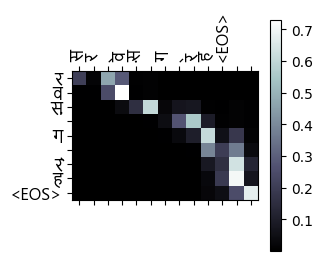

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import time

TTF_PATH = '/mnt/media/guest1/abhijeet/assignments/deep_learning/assignment_03/attention_seq_to_seq/aksharantar_sampled/hin/Nirmala.ttf'
font_prop = FontProperties(fname=TTF_PATH, size=12)

def showAttention(input_sentence, target_sentence, output_words, attentions):
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
    ax.set_yticklabels([''] + output_words, fontproperties=font_prop)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('Input:', input_sentence)
    print('Target:', target_sentence)
    print('Predicted Output:', ''.join(output_words))
    showAttention(input_sentence, target_sentence, output_words, attentions[0, :len(output_words), :])

# Get 10 samples from the training set and visualize attention for each
for i in range(10):
    print(f"Processing example {i+1}")
    input_sentence, target_sentence = get_example_from_csv(TRAIN_PATH, i)  # Implement this function to get examples from your dataset
    evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang)
    time.sleep(3)


Input: thermax
Target: थरमैक्स
Predicted Output: र्रमैक्स<EOS>
Input: sikhaaega
Target: सिखाएगा
Predicted Output: आईगा<EOS>
Input: learn
Target: लर्न
Predicted Output: र्न<EOS>
Input: twitters
Target: ट्विटर्स
Predicted Output: ट्विटर्स<EOS>


/tmp/ipykernel_75012/871744728.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/871744728.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)
/tmp/ipykernel_75012/871744728.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/871744728.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_pr

Input: tirunelveli
Target: तिरुनेलवेली
Predicted Output: रियूनेलवेली<EOS>
Input: independence
Target: इंडिपेंडेंस
Predicted Output: इंडेंडेंस<EOS>
Input: speshiyon
Target: स्पेशियों
Predicted Output: स्पेशियों<EOS>
Input: shurooh
Target: शुरूः
Predicted Output: रूरह<EOS>


/tmp/ipykernel_75012/871744728.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/871744728.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)
/tmp/ipykernel_75012/871744728.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/871744728.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_pr

Input: kolhapur
Target: कोल्हापुर
Predicted Output: लोहापुर<EOS>
Input: ajhar
Target: अजहर
Predicted Output: आरार<EOS>
Input: karaar
Target: क़रार
Predicted Output: करार<EOS>
Input: anka
Target: अंक
Predicted Output: कैका<EOS>


/tmp/ipykernel_75012/871744728.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/871744728.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)
/tmp/ipykernel_75012/871744728.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/871744728.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_pr

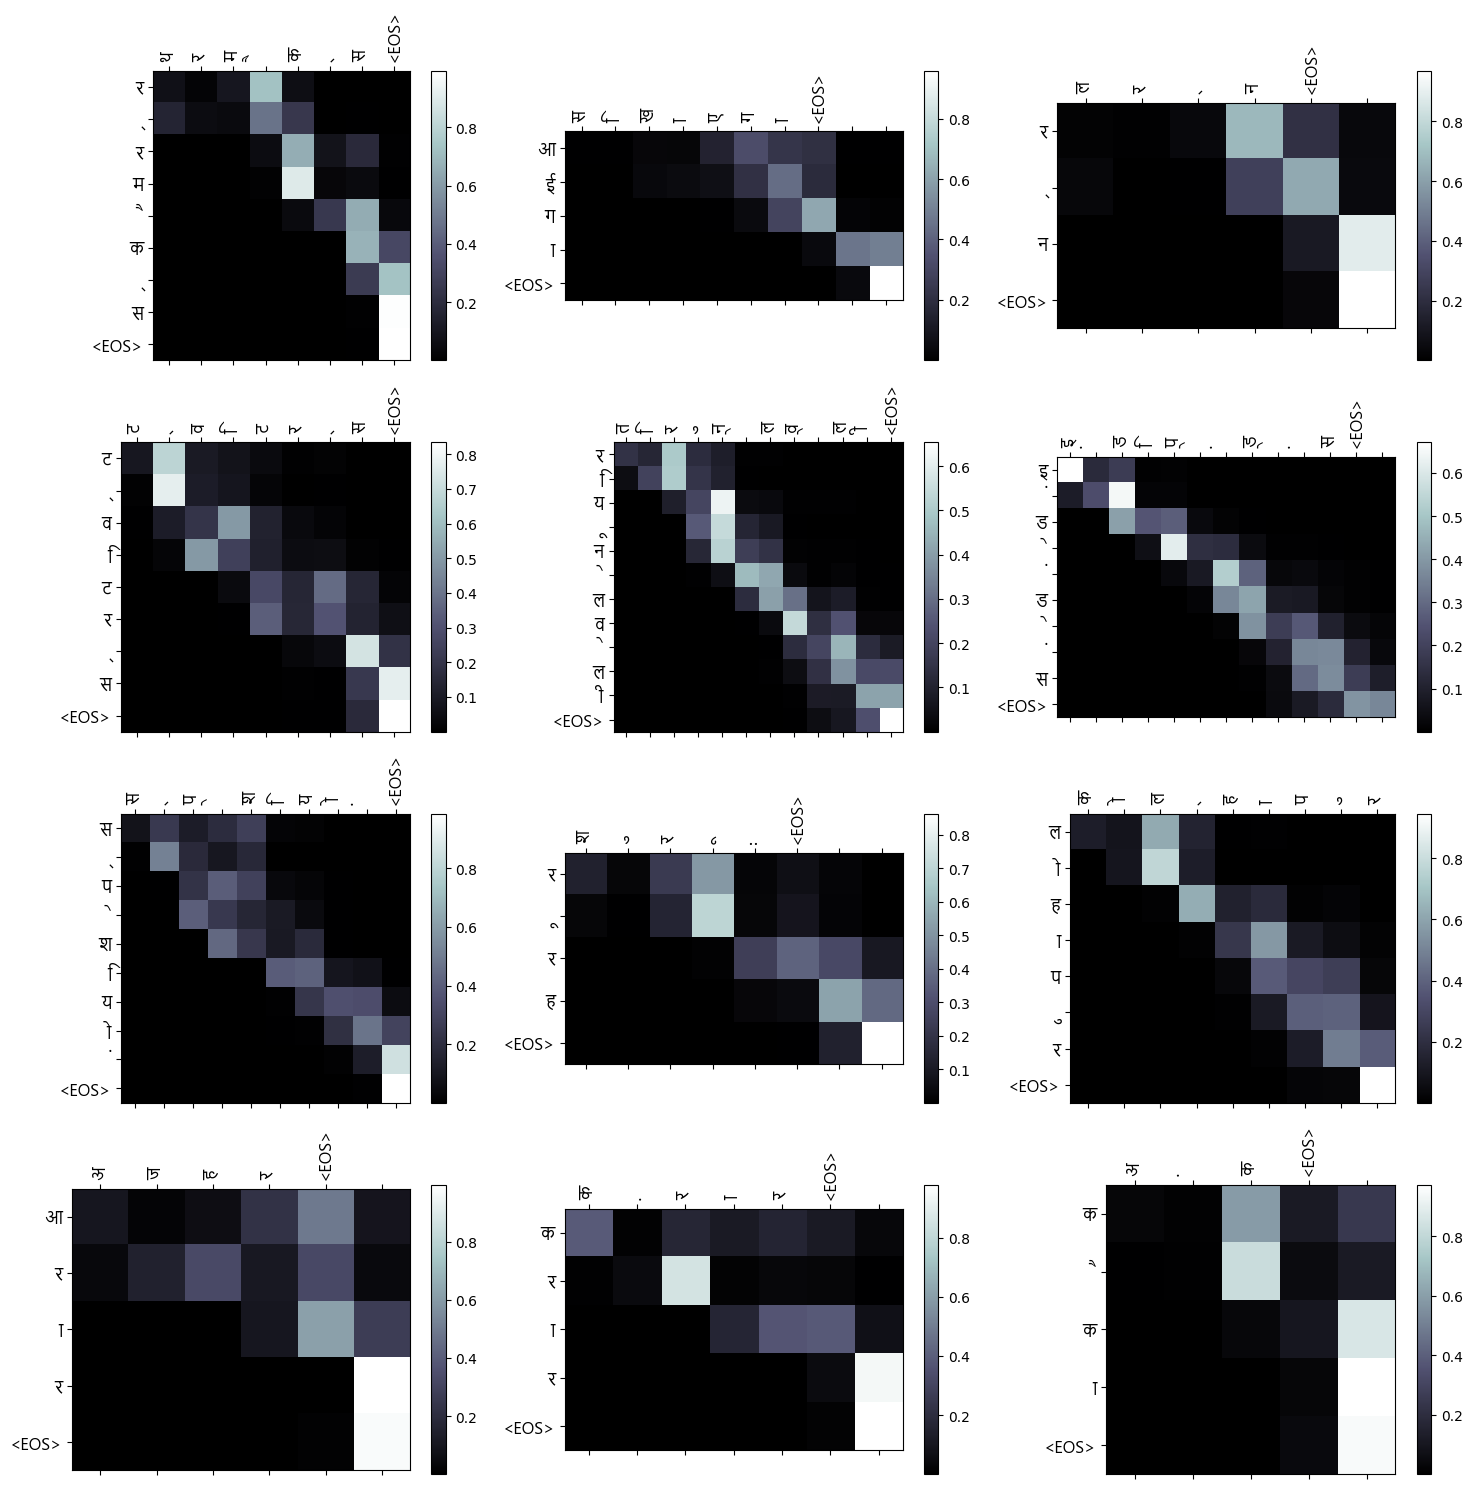

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import csv

TTF_PATH = '/mnt/media/guest1/abhijeet/assignments/deep_learning/assignment_03/attention_seq_to_seq/aksharantar_sampled/hin/Nirmala.ttf'
font_prop = FontProperties(fname=TTF_PATH, size=12)

def showAttention(input_sentence, target_sentence, output_words, attentions, ax):
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax, ax=ax)

    # Set up axes
    ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
    ax.set_yticklabels([''] + output_words, fontproperties=font_prop)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

def evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang, ax):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('Input:', input_sentence)
    print('Target:', target_sentence)
    print('Predicted Output:', ''.join(output_words))
    showAttention(input_sentence, target_sentence, output_words, attentions[0, :len(output_words), :], ax)

# Load examples from CSV
examples = []
with open(TEST_PATH, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    examples = list(reader)

# Create subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Get 10 samples and visualize attention for each
for i, ax in enumerate(axs.flat):
    if i < len(examples):
        input_sentence, target_sentence = examples[i]
        evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang, ax)
    else:
        # If there are fewer than 10 examples, leave the subplot empty
        ax.axis('off')

plt.tight_layout()
plt.show()


Input: thermax
Target: थरमैक्स
Predicted Output: र्रमैक्स<EOS>
Input: sikhaaega
Target: सिखाएगा
Predicted Output: आईगा<EOS>
Input: learn
Target: लर्न
Predicted Output: र्न<EOS>
Input: twitters
Target: ट्विटर्स
Predicted Output: ट्विटर्स<EOS>


/tmp/ipykernel_75012/2965663611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2965663611.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)
/tmp/ipykernel_75012/2965663611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2965663611.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=fon

Input: tirunelveli
Target: तिरुनेलवेली
Predicted Output: रियूनेलवेली<EOS>
Input: independence
Target: इंडिपेंडेंस
Predicted Output: इंडेंडेंस<EOS>
Input: speshiyon
Target: स्पेशियों
Predicted Output: स्पेशियों<EOS>
Input: shurooh
Target: शुरूः
Predicted Output: रूरह<EOS>


/tmp/ipykernel_75012/2965663611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2965663611.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)
/tmp/ipykernel_75012/2965663611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2965663611.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=fon

Input: kolhapur
Target: कोल्हापुर
Predicted Output: लोहापुर<EOS>


/tmp/ipykernel_75012/2965663611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_75012/2965663611.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)


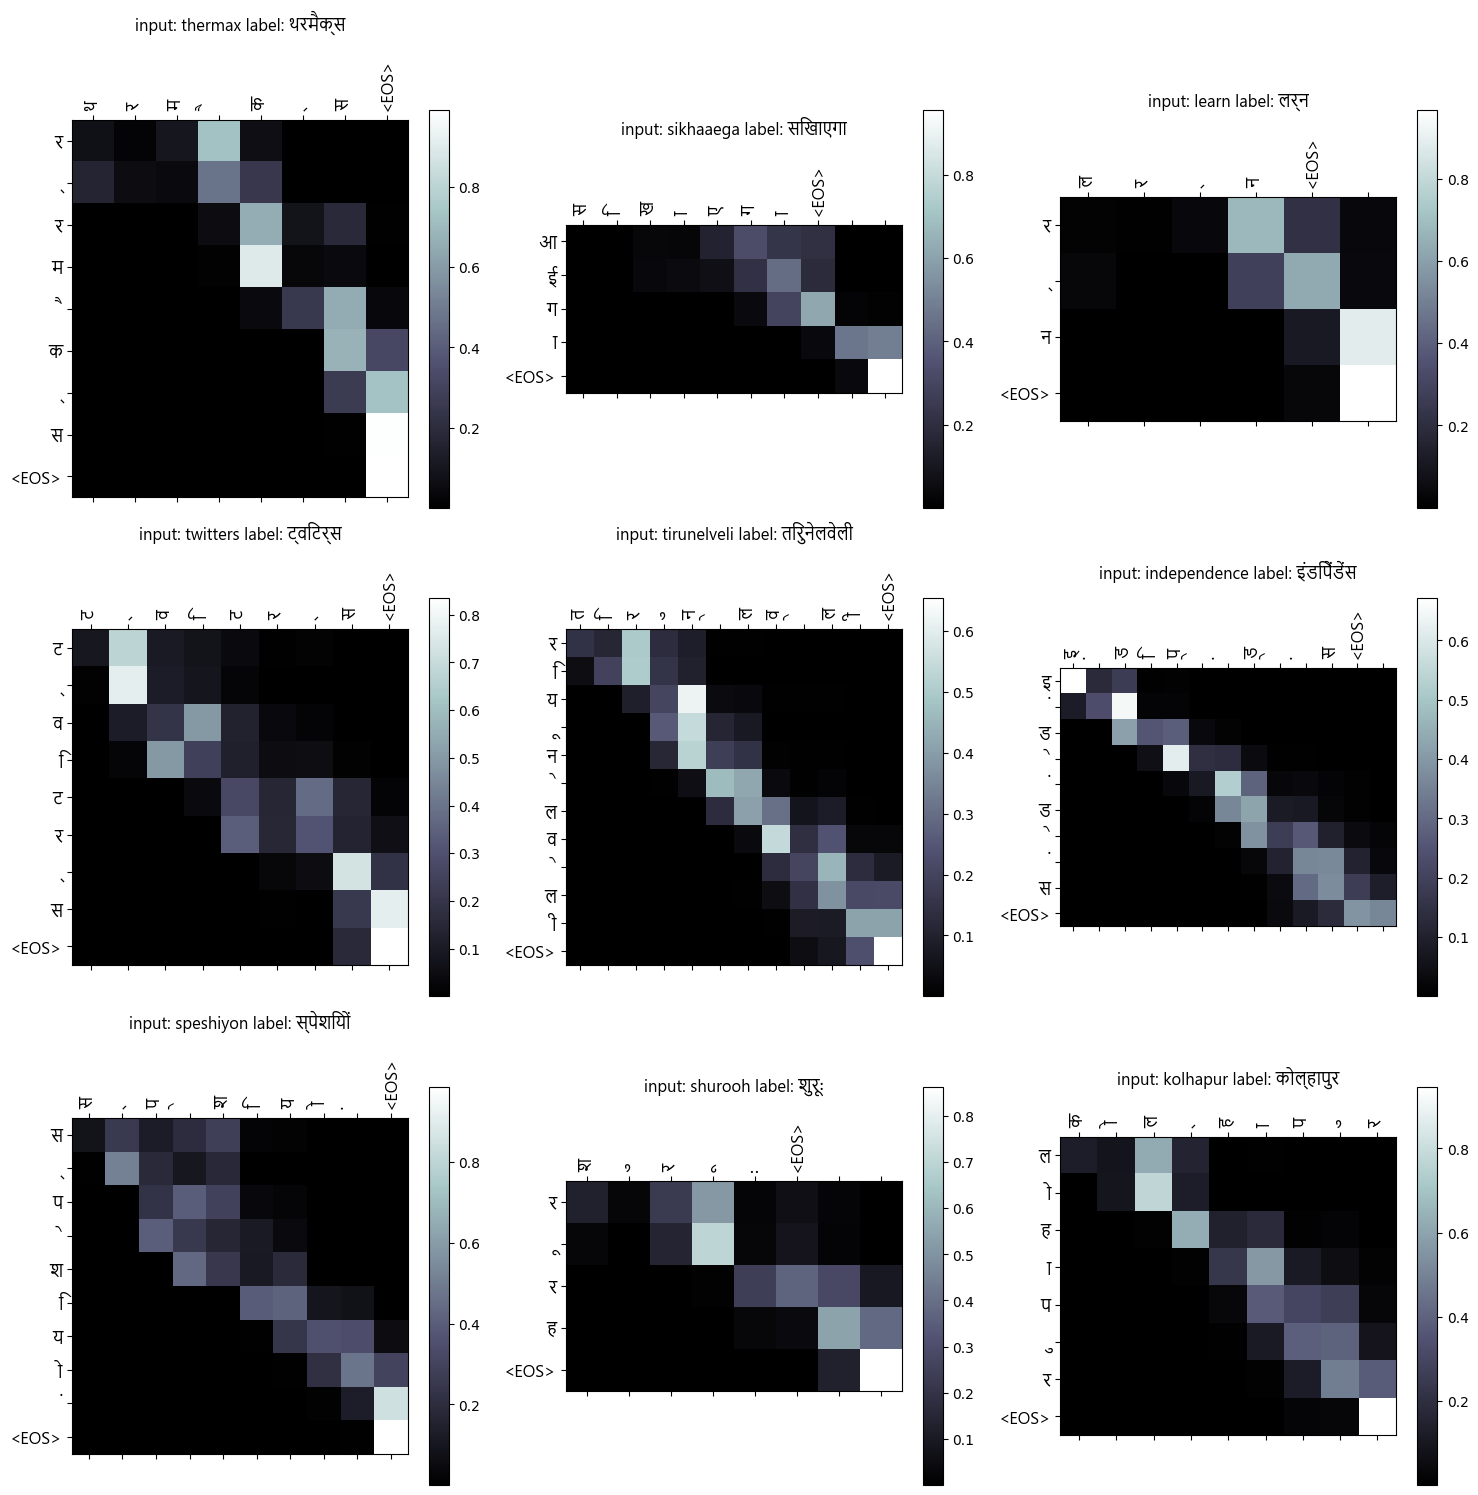

In [82]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import csv

TTF_PATH = '/mnt/media/guest1/abhijeet/assignments/deep_learning/assignment_03/attention_seq_to_seq/aksharantar_sampled/hin/Nirmala.ttf'
font_prop = FontProperties(fname=TTF_PATH, size=12)

def showAttention(input_sentence, target_sentence, output_words, attentions, ax):
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax, ax=ax)

    # Set up axes
    ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
    ax.set_yticklabels([''] + output_words, fontproperties=font_prop)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

def evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang, ax):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('Input:', input_sentence)
    print('Target:', target_sentence)
    print('Predicted Output:', ''.join(output_words))
    showAttention(input_sentence, target_sentence, output_words, attentions[0, :len(output_words), :], ax)

# Load examples from CSV
examples = []
with open(TEST_PATH, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    examples = list(reader)

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Get 10 samples and visualize attention for each
for i, ax in enumerate(axs.flat):
    if i < len(examples):
        input_sentence, target_sentence = examples[i]
        ax.set_title(f"input: {input_sentence}\n output: {target_sentence}", fontproperties=font_prop)
        evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang, ax)
    else:
        # If there are fewer than 10 examples, leave the subplot empty
        ax.axis('off')

plt.tight_layout()
plt.show()
